# Classification Algorithms

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
from sklearn.metrics import roc_auc_score

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#### Load the dataframe

In [2]:
data_org= pd.read_csv("Twitter-Absolute-Sigma-500.data",sep=',',header=None)

#### Display the first 5 rows of data

In [3]:
data_org.head(5)

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,889,939,960,805,805,1143,1121,549,613,587,...,1.0,1.0,889,939,960,805,805,1143,1121,1.0
1,542,473,504,626,647,795,832,366,288,318,...,1.0,1.0,542,473,504,626,647,795,832,1.0
2,92,99,196,100,184,79,162,66,59,118,...,1.0,1.0,92,99,196,100,184,79,162,0.0
3,90,87,92,344,184,848,184,83,78,76,...,1.0,1.0,90,87,92,344,184,848,184,1.0
4,169,98,101,90,96,95,185,141,68,85,...,1.0,1.0,169,98,101,90,96,95,185,1.0


#### Assigning the Predictor and Target Variables

In [4]:
X=data_org.loc[:,0:76]
y=data_org.loc[:,77]
print(X.shape)
print(y.shape)

(140707, 77)
(140707,)


####  Split the data into train and test samples, Scale the data

In [5]:
# Load the Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Randomizing the dataset and using 10% of the dataset for building models

_,sample_data,_,sample_target = train_test_split(X, y, shuffle = True, test_size = 0.1)

# Splitting data train / test ratio of 80:20                                      
X_train, X_test, y_train, y_test = train_test_split(sample_data, sample_target, random_state = 0, test_size = 0.2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hard Voting Decision Tree and KNN

Hard Voting simply aggregate the predictions of each classifier and predict the class that gets the most votes.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

#Train Logistic Regression
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)


#Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#Train voting classifer with Logistic Regression and Random Forest models
voting_clf = VotingClassifier(estimators=[('Tree', tree),('kNN', knn)], voting='hard')
voting_clf.fit(X_train, y_train)

for clf in (tree,knn, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy of {} : {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))  

Accuracy of DecisionTreeClassifier : 0.9452930728241563
Accuracy of KNeighborsClassifier : 0.9573712255772646
Accuracy of VotingClassifier : 0.9523978685612788


# Soft Voting Logistic Regression and Random Forest

####  For Soft Voting change the argument voting ='Soft'

Soft Voting predict the class with the highest class probability, averaged over all the individual classifiers.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

#Train Logistic Regression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)


#Train Random Forest
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rnd_clf.fit(X_train, y_train)

#Train voting classifer with Logistic Regression and Random Forest models
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('RF', rnd_clf)],voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf,rnd_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy of {} : {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))

Accuracy of LogisticRegression : 0.9534635879218473
Accuracy of RandomForestClassifier : 0.9680284191829485
Accuracy of VotingClassifier : 0.9644760213143873


#### Learning: Soft Voting works slightly better than Hard voting for our data considering 3 decimals of accuracy.

#### This might be beacuse soft voting gives more weight to highly probable votes.

# Bagging with Decision Trees and SVM

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import accuracy_score
from sklearn.svm import SVC

dt_clf = DecisionTreeClassifier(random_state=0)
svc_clf = SVC()

clf_array = [dt_clf, svc_clf]
for clf in clf_array:
    reg_clf = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    bag_clf = BaggingClassifier(clf,n_estimators=100, max_samples=100, bootstrap=True, n_jobs=-1, random_state=0)
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    print("Accuracy of {} : {}".format(clf.__class__.__name__,reg_clf.mean()))
    print("Accuracy of {} with Bagging : {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))

Accuracy of DecisionTreeClassifier : 0.9466950942663731
Accuracy of DecisionTreeClassifier with Bagging : 0.9669626998223801
Accuracy of SVC : 0.899164649932574
Accuracy of SVC with Bagging : 0.7996447602131439


#### Learning:Accuracy of models created with bagging have higher accuracy scores  
#### It is less overfitted than a single individual model   
#### This is because bagging helps decrease the variance of the classifier and reduce overfitting, by resampling data from the training.

# Pasting with Decision Trees and SVM


Pasting and Bagging are very similar, the main difference being that Bagging samples with replacement (which is called "bootstrapping") while Pasting samples without replacement.

#### For pasting change argument to bootstrap=False

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import accuracy_score
from sklearn.svm import SVC

dt_clf = DecisionTreeClassifier(random_state=0)
svc_clf = SVC()

clf_array = [dt_clf, svc_clf]
for clf in clf_array:
    reg_clf = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    bagg_clf = BaggingClassifier(clf,n_estimators=100, max_samples=100, bootstrap=False, n_jobs=-1, random_state=0)
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    print("Accuracy of {} : {}".format(clf.__class__.__name__,reg_clf.mean()))
    print("Accuracy of {} with Pasting : {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))
    

Accuracy of DecisionTreeClassifier : 0.9466950942663731
Accuracy of DecisionTreeClassifier with Pasting : 0.7996447602131439
Accuracy of SVC : 0.899164649932574
Accuracy of SVC with Pasting : 0.7996447602131439


## Ada Boosting with Decision Trees

In [12]:
# Import the Library
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

#Train Ada boost classifier object
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=0)
ada_clf.fit(X_train, y_train)
ada_y_pred=ada_clf.predict(X_test)
print("Accuracy on training set: {:.3f}".format(ada_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ada_clf.score(X_test, y_test)))
print("Accuracy of Ada boost with Decision Tree:",metrics.accuracy_score(y_test, ada_y_pred))


Accuracy on training set: 0.972
Accuracy on test set: 0.963
Accuracy of Ada boost with Decision Tree: 0.9626998223801065


# Ada Boosting with Logistic Regression

In [20]:
# Import Support Vector Classifier
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression()


# Create adaboost classifer object
ada_clf =AdaBoostClassifier(n_estimators=50,base_estimator=logit,learning_rate=1)

# Train Adaboost Classifer
ada_clf.fit(X_train, y_train)
model_pred=ada_clf.predict(X_test)

print("Accuracy on training set: {:.3f}".format(ada_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ada_clf.score(X_test, y_test)))
print("Accuracy of Ada Boost with Logistic Regression:",metrics.accuracy_score(y_test, model_pred))

Accuracy on training set: 0.828
Accuracy on test set: 0.824
Accuracy of Ada Boost with Logistic Regression: 0.8238010657193605


# Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.5, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    model_pred=gb.predict(X_test)
    print("Learning rate: ", learning_rate)
    print("Accuracy score on training set : {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score on testing set : {0:.3f}".format(gb.score(X_test, y_test)))
    print("Accuracy of Gradient Boost :",metrics.accuracy_score(y_test, model_pred))
    

Learning rate:  0.5
Accuracy score on training set : 0.971
Accuracy score on testing set : 0.966
Accuracy of Gradient Boost : 0.9655417406749556
Learning rate:  1
Accuracy score on training set : 0.972
Accuracy score on testing set : 0.964
Accuracy of Gradient Boost : 0.9641207815275311


# PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

#print("Pca components are {}".format(pca.components_))
print("Proportion of explained variance {}".format(pca.explained_variance_))

Proportion of explained variance [0.51804474 0.18075515]


#### Pca components PCA1 and PCA 2 accounts for about 67% of the total variation in dataset

In [23]:
print("original shape:   ", X.shape)
print("Transformed shape:", X_pca.shape)

original shape:    (140707, 77)
Transformed shape: (11256, 2)


#### From the above result we understand that by projecting data into lower dimensional space 
#### Just 2 features and 11256 instances are sufficient enough to account for maximal variance in the data

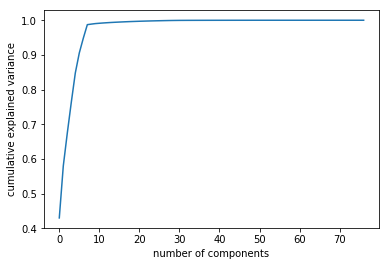

In [24]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 77-dimensional variance is contained within the first N components.  see that with 5-6 components contain approximately 90% of the variance, while you need around 10 components to describe close to 100% of the variance.

For simplicity all the models are trained using 0.95 variance 

In [26]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

train_img = pca.transform(X_train)
test_img = pca.transform(X_test)


#### Decision Tree with PCA   Hyperparameters:max_depth=5,criterion='gini'
    

In [28]:
# Import Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# Decision Tree with default parameters Gini Index,Max_depth=0
dtree_tuned = DecisionTreeClassifier(random_state=0,max_depth=5,splitter='best',criterion='gini')
dtree= DecisionTreeClassifier(random_state=0,max_depth=5,splitter='best',criterion='gini')
dtree_tuned.fit(train_img, y_train)
dtree.fit(X_train, y_train)

print("Accuracy score on training set : {0:.3f}".format(dtree_tuned.score(train_img, y_train)))
print("Accuracy score on testing set : {0:.3f}".format(dtree_tuned.score(test_img, y_test)))

report_table = [['Decision Tree', 'Gini Index ,Max depth=5',dtree.score(X_train, y_train),dtree.score(X_test, y_test)]]
report_table =report_table+ [['Decision Tree with PCA', 'Gini Index ,Max depth=5',dtree_tuned.score(train_img, y_train),dtree_tuned.score(test_img, y_test)]]

Accuracy score on training set : 0.961
Accuracy score on testing set : 0.956


#### Logistic Regression with PCA  Hyperparameters : C1 ,L1

In [29]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(penalty = 'l1', C = 1)
log = LogisticRegression(penalty = 'l1', C = 1)
log.fit(X_train,y_train)
logisticRegr.fit(train_img,y_train)

print("Accuracy score on training set : {0:.3f}".format(logisticRegr.score(train_img, y_train)))
print("Accuracy score on testing set : {0:.3f}".format(logisticRegr.score(test_img, y_test)))

report_table =report_table +[['Logistic Regression','L1,C=1',log.score(X_train,y_train),log.score(X_test,y_test)]]
report_table =report_table +[['Logistic Regression with PCA','L1,C=1',logisticRegr.score(train_img,y_train),logisticRegr.score(test_img,y_test)]]

Accuracy score on training set : 0.958
Accuracy score on testing set : 0.956


#### K Nearest Neighbors with PCA Hyperparameters : K=4

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(train_img, y_train)

knn_clf=KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train,y_train)


print('Accuracy score on training set: {:.3f}'.format(knn.score(train_img, y_train)))
print('Accuracy score on testing set : {:.3f}'.format(knn.score(test_img, y_test)))

report_table =report_table + [['KNN', 'K=4',knn_clf.score(X_train, y_train),knn_clf.score(X_test, y_test)]]
report_table =report_table + [['KNN With PCA', 'K=4',knn.score(train_img, y_train),knn.score(test_img, y_test)]]

Accuracy score on training set: 0.963
Accuracy score on testing set : 0.952


#### SVM with PCA Hyperparameters :C=10, Gamma=1

In [33]:
from sklearn.svm import SVC
svc_lin=SVC(kernel='linear',C=10,gamma=1)
svc_lin.fit(train_img,y_train)

svc=SVC(kernel='linear',C=10,gamma=1)
svc.fit(X_train,y_train)

print('Accuracy score on training set: {:.3f}'.format(svc_lin.score(train_img, y_train)))
print('Accuracy score on testing set : {:.3f}'.format(svc_lin.score(test_img, y_test)))


report_table = report_table + [['LinearSVC', 'C = 10', svc.score(X_train, y_train), svc.score(X_test, y_test)]]
report_table = report_table + [['LinearSVC with PCA', 'C = 10', svc_lin.score(train_img, y_train), svc_lin.score(test_img, y_test)]]

Accuracy score on training set: 0.958
Accuracy score on testing set : 0.957


In [34]:
report = pd.DataFrame(report_table,columns = ['Model name', 'Model parameter', 'Train accuracy', 'Test accuracy'])
report.index = report['Model name']
report

,Model name,Model parameter,Train accuracy,Test accuracy
Model name,,,,
Decision Tree,Decision Tree,"Gini Index ,Max depth=5",0.971393,0.963055
Decision Tree with PCA,Decision Tree with PCA,"Gini Index ,Max depth=5",0.960554,0.955950
Logistic Regression,Logistic Regression,"L1,C=1",0.963486,0.966252
Logistic Regression with PCA,Logistic Regression with PCA,"L1,C=1",0.957534,0.955595
KNN,KNN,K=4,0.967484,0.956661
KNN With PCA,KNN With PCA,K=4,0.962598,0.952398
LinearSVC,LinearSVC,C = 10,0.965441,0.966252
LinearSVC with PCA,LinearSVC with PCA,C = 10,0.958156,0.956661


####  Learning : From the above table it is clearly evident that the model accuracy improved on using PCA for dimension reduction

# Deep Learning

input_dim parameter : needed only for first layer , we have 77 input variables
Activation function : must be as close as possible to 1. I have chosen rectifier function in hidden layer and sigmoid function in the output layer


In [37]:
from keras.models import Sequential
from keras.layers import Dense
# create model
model = Sequential()
model.add(Dense(12, input_dim=77, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=150, batch_size=10)


# evaluate the model
scores = model.evaluate(X_test, y_test)
print("Accuracy\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
11256/11256 [==============================] - 1s 103us/step - loss: 0.2223 - acc: 0.9120
Epoch 2/150
11256/11256 [==============================] - 1s 75us/step - loss: 0.1080 - acc: 0.9574
Epoch 3/150
11256/11256 [==============================] - 1s 72us/step - loss: 0.1040 - acc: 0.9581
Epoch 4/150
11256/11256 [==============================] - 1s 70us/step - loss: 0.1014 - acc: 0.9607
Epoch 5/150
11256/11256 [==============================] - 1s 69us/step - loss: 0.1003 - acc: 0.9621
Epoch 6/150
11256/11256 [==============================] - 1s 70us/step - loss: 0.0982 - acc: 0.9630
Epoch 7/150
11256/11256 [==============================] - 1s 71us/step - loss: 0.0984 - acc: 0.9620
Epoch 8/150
11256/11256 [==============================] - 1s 70us/step - loss: 0.0970 - acc: 0.9625
Epoch 9/150
11256/11256 [==============================] - 1s 75us/step - loss: 0.0958 - acc: 0.9620
Epoch 10/150
11256/11256 [==============================] - 1s 77us/step - loss: 0.0956 - 

11256/11256 [==============================] - 1s 75us/step - loss: 0.0879 - acc: 0.9653
Epoch 82/150
11256/11256 [==============================] - 1s 83us/step - loss: 0.0879 - acc: 0.9654
Epoch 83/150
11256/11256 [==============================] - 1s 112us/step - loss: 0.0876 - acc: 0.9657
Epoch 84/150
11256/11256 [==============================] - 1s 93us/step - loss: 0.0888 - acc: 0.9646
Epoch 85/150
11256/11256 [==============================] - 1s 78us/step - loss: 0.0882 - acc: 0.9655
Epoch 86/150
11256/11256 [==============================] - 1s 80us/step - loss: 0.0882 - acc: 0.9648
Epoch 87/150
11256/11256 [==============================] - 1s 80us/step - loss: 0.0877 - acc: 0.9659
Epoch 88/150
11256/11256 [==============================] - 1s 84us/step - loss: 0.0882 - acc: 0.9654
Epoch 89/150
11256/11256 [==============================] - 1s 77us/step - loss: 0.0880 - acc: 0.9648
Epoch 90/150
11256/11256 [==============================] - 1s 76us/step - loss: 0.0877 - acc:

#### Summary:
While Voting - ensembler helps us combine the power of multiple model to improve prediction.
Bagging can help in minimizing the variance by creating subsets of data
Boosting reduces the possibility of misclassification of data 
PCA captures variability in data and provides a way to represent the data using minimal number of features and instances
